# Residual Networks

이번 실습에서는 아주 깊은 CNN인 Residual Networks를 직접 구현해본다. 일반적으로 아주 깊은 neural network는 아주 복잡한 함수를 학습할 수 있지만 학습이 어렵다.
논문 [He et al.](https://arxiv.org/pdf/1512.03385.pdf)이 소개한 Residual Network는 아주 깊은 모델을 학습할 수 있는 방법을 제안하였다.

이 실습은 아래 과정으로 이루어진다:
- skip connection을 포함한 ResNets의 기본 building block을 pytorch로 직접 구현한다.
- building block을 쌓아 resnet을 구현하고 이미지 분류를 시도한다.
- pytorch에서 제공하는 pre-trained model을 이용하여 transfer learning을 수행한다.

In [20]:
import torch
from torch import nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision import models

import wandb

from training_utilities import train_loop, evaluation_loop, create_dataloaders, save_checkpoint, load_checkpoint

from torch.utils.data import DataLoader

## The Problem of Very Deep Neural Networks

최근 neural network는 점점더 깊어지고 있으며 AlexNet이 몇개의 layer만 가졌다면 최신 neural network는 수백개의 layer들로 이루어진다.

* 깊은 네트워크의 가장 중요한 장점은 아주 복잡한 함수도 학습할 수 있다는 것이다. 따라서 edges와 같이 간단한 feature부터 아주 복잡한 features까지 다양한 층위의 feature들을 학습할 수 있다

* 하지만 신경망이 깊어지는것이 항상 좋은 결과를 만드는 것은 아니다. 가장 큰 어려움은 vanishing gradients로, 깊은 신경망에서 gradient값이 아주 빨리 0에 가까워져 학습이 아주 느려지는 것이다.

* 좀더 구체적으로는 backpropagate이 마지막 레이어(layer)부터 첫번째 레이어까지 진행되는 과정에서, weight matrix가 계속해서 곱해지며 따라서 gradient값이 기하급수적으로 빠르게 0으로 수렴한다. (또는 아주 드물게 gradient값이 기하급수적으로 증가하여 gradient explode가 발생하기도 함). 

* 따라서 아래와 같이 학습과정에서 얕은 layer의 gradient의 크기(norm)가 빠르게 0으로 감소하는 것을 확인할 수 있다.

<center><img src="resources/vanishing_grad_kiank.png" style="width:450px;height:220px;"></center>
<caption><center> <u> <b>Figure</b> </u>  : <b>Vanishing gradient</b> <br> 얕은 레이어에서 학습 속도가 아주 빠르게 감소한다 </center></caption>


이러한 문제를 ResNet을 통해 해결할 수 있다

## Building a Residual Network

ResNets 에서는 "shortcut" 또는 "skip connection" 을 통해 레이어를 스킵할수 있도록 해준다.

<center><img src="resources/skip_connection_kiank.png" style="width:650px;height:200px;"></center>
<caption><center> <u> <b>Figure</b> </u>  : skip-connection <br> </center></caption>

왼쪽 이미지는 신경망의 "main path"를 보여준다. 오른쪽의 이미지는 shortcut를 추가한 것이다. 
이러한 ResNet blocks 쌓음으로써 아주 깊은 신경망을 학습할 수 있다.

shortcut이 있는 ResNet block은 항등함수(identity function)를 학습하기 아주 쉬워진다 (모든 weight가 0이면 항등함수).  이는 이 ResNet block을 쌓는것으로 인한 성능 저하가 거의 없을 것임을 의미한다.  
    
그런 측면에서 ResNet이 항등 함수를 배우기 쉬운 것으로 인한 효과가 skip connection으로 vanishing gradients문제를 완화하는 것으로 인한 효과보다 더 크다는 보고들도 존재한다.

ResNet에는 input과 output의 차원이 같은지 다른지에 따라 "identity block", "convolutional block" 이렇게 크게 두가지 종류의 block이 존재한다. 각각을 구현해보자.

### The Identity Block

identity block은 ResNet의 기본 블럭으로, 입력 activation(예 $a^{[l]}$)와 출력 activation (예 $a^{[l+2]}$)이 같은 차원일때 사용된다.

<center><img src="resources/idblock2_kiank.png" style="width:650px;height:150px;"></center>
<caption><center> <u> <b>Figure</b> </u> : <b>2개의 레이어를 건너뛰는 Identity block.</b> </center></caption>

학습 속도를 향상시키기 위한 BatchNorm 레이어가 포함되어 있다.

이 블럭은 ResNet18, ResNet34에서 사용되며,

ResNet50부터는 이보다 더 효과적인 3개의 hidden layer를 건너뛰는 identity block을 사용한다

<center><img src="resources/idblock3_kiank.png" style="width:650px;height:150px;"></center>
    <caption><center> <u> <b>Figure</b> </u>  : <b>3개의 레이어를 건너뛰는 Identity block.</b> </center></caption>

좀더 구체적으로는 아래 그림의 우측과 같이 Bottleneck block이라고도 불리는 구조를 사용하며 1x1 conv를 통해 필터 수를 줄여 3x3 conv를 수행하고 다시 늘림으로써 layer의 수는 더 많아졌지만 computation은 줄어들어 더 효율적이며 non-linearity도 많아졌다.

<center><img src="resources/Basic Block_1.png" style="width:264px;">  <img src="resources/Bottleneck Block_2.png" style="width:300px;"></center>

<mark>과제</mark> Identity block을 구현하라

1. main path의 첫번째 layer
- 첫번째 Conv2d는 ``intermediate_channels``개의 1x1 필터와 stride = 1, "valid" padding으로 이루어져 있다. BatchNorm을 수행할 것이므로 bias = False이다.
- BatchNorm은 'channels'축으로 데이터를 normalize한다.
- ReLU activation function을 적용한다 (hyperparameter는 없음)

2. main path의 두번쨰 layer
- 두번째 Conv2d는 ``intermediate_channels``개의 3x3 필터와 stride = 1, "same" padding으로 이루어져 있다. (conv후 이미지 크기가 같음). bias = False이다.
- BatchNorm
- ReLu

3. main path의 세번째 layer
- 세번째 Conv2d는 ``intermediate_channels`` x ``expansion``개의 1x1 필터와 stride = 1, "valid" padding으로 이루어져 있다. bias = False이다.
- BatchNorm
- ReLU activation은 **없다**

4. Shortcut path
- Conv의 결과와 입력값이 더해진다
- 그 후 ReLU activation을 취한다.

아래 documentation을 참고하여 구현하라.
- [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) : 만약 모델이 eval모드일 경우 weight가 업데이트 되지 않는다. 
- [ReLu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)


In [8]:
class IdentityBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, intermediate_channels):
        super().__init__()

        ##### YOUR CODE START #####
        # main path의 첫 번째 layer
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding='valid', bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.relu = nn.ReLU()

        # main path의 두 번째 layer
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False)  # same padding
        self.bn2 = nn.BatchNorm2d(intermediate_channels)

        # main path의 세 번째 layer
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        ##### YOUR CODE END #####

    def forward(self, x):
        ##### YOUR CODE START #####
        identity = x  # 입력을 저장해 둠

        # main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # shortcut path: 입력값과 main path의 결과를 더함
        out += identity
        out = self.relu(out)
        ##### YOUR CODE END #####
        
        return out

### The Convolutional Block

ResNet "convolutional block"은 두번쨰 형태의 블럭으로 input과 output차원이 맞지 않을때 사용할 수 있다. indentity block과의 차이는 shortcut path에 Conv2D레이어가 존재한다는 것이다

<center><img src="resources/convblock_kiank.png" style="width:650px;height:150px;"></center>
<caption><center> <b>Convolutional block</b> </center></caption>

* shortcut path의 Conv2D레이어는 입력 $x$를 다른 차원으로 매핑하여 main path의 출력값과 일치시키는데 사용된다.
* 예를들어 공간 차원의 height와 width를 1/2로 줄이려면 1x1 convolution을 stride = 2로 수행한다. 
* 이 Conv2D 레이어는 non-linear activation 함수를 적용하지 않는다. 주된 목적이 입력 차원을 줄이는 선형 함수를 학습하는 것이기 때문이다.


<mark>과제</mark> Convolution Block을 구현하라

1. main path의 첫번째 레이어
- 첫번째 Conv2d는 `intermediate_channels`개의 1x1 필터와 stride = 1, "valid" padding, bias = False이다.
- BatchNorm
- ReLU activation

2. main path의 두번째 레이어
- 두번째 Conv2d는 `intermediate_channels`개의 3x3필터와 stride = stride, padding = 1, bias = False이다.
- BatchNorm
- ReLU activation

3. main path의 세번째 레이어
- 세번째 Conv2d는 ``intermediate_channels`` x ``expansion``개의 1x1 필터와 stride = 1, "valid" padding, bias = False이다.
- BatchNorm
- ReLU activation
- **No** ReLU activation 

4. Shortcut path
- shortcut path의 Conv2d는 ``intermediate_channels`` x ``expansion``개의 1x1 필터와 stride = stride, "valid" padding, bias = False이다.
- BatchNorm

5. Final step: 
- shortcut과 main path의 값을 더한다
- ReLU activation function

In [9]:
class ConvBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, intermediate_channels, stride):
        super().__init__()

        ##### YOUR CODE START #####
        # main path의 첫 번째 layer
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding='valid', bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.relu = nn.ReLU()

        # main path의 두 번째 layer
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)

        # main path의 세 번째 layer
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)

        # shortcut path
        self.shortcut = nn.Conv2d(in_channels, intermediate_channels * self.expansion, kernel_size=1, stride=stride, padding='valid', bias=False)
        self.bn_shortcut = nn.BatchNorm2d(intermediate_channels * self.expansion)
        ##### YOUR CODE END #####

    def forward(self, x):
        ##### YOUR CODE START #####
        identity = x  # 입력 저장

        # main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # shortcut path
        shortcut = self.shortcut(identity)
        shortcut = self.bn_shortcut(shortcut)

        # main path와 shortcut path 더하기
        out += shortcut
        out = self.relu(out)
        ##### YOUR CODE END #####

        return out

## Building Your ResNet Model (50 layers)

이제 ResNet50을 쌓기위한 블럭이 모두 완성되었다. 아래 그림은 ResNet구조를 나타내며, "ID BLOCK"은 Identity block을, "ID BLOCK x3"은 identity block을 3개 쌓는것을 의미한다.

<center><img src="resources/resnet_kiank.png" style="width:850px;height:150px;"></center>
<caption><center> <b>ResNet-50 model</b> </center></caption>

<mark>과제</mark> 50개의 레이어가 있는 ResNet50 모델을 구현하라.
ResNet-50 모델은 아래와 같이 이루어져 있다.
- Stage 1 (Stem):
    - 64개의 7x7 필터를 가지고 stride = 2, padding = 3인 Conv2D레이어 (bias=False)
    - BatchNorm
    - ReLU activation
    - stride = 2, kernel_size = 3, padding = 1인 MaxPool2d
- Stage 2 (3 layer):
    - intermediate_channels = 64, expansion = 4, stride = 1인 convolutional block 
    - intermediate_channels = 64, expansion = 4인 2개의 identity block
- Stage 3 (4 layer):
    - intermediate_channels = 128, expansion = 4, stride = 2인 convolutional block 
    - intermediate_channels = 128, expansion = 4인 3개의 identity block
- Stage 4 (6 layer):
    - intermediate_channels = 256, expansion = 4, stride = 2인 convolutional block 
    - intermediate_channels = 256, expansion = 4인 5개의 identity block
- Stage 5 (3 layer):
    - intermediate_channels = 512, expansion = 4, stride = 2인 convolutional block 
    - intermediate_channels = 512, expansion = 4인 2개의 identity block
- AdaptiveAvgPool2d를 이용한 2D Average Pooling (output = 1x1)
- Flatten layer
- Linear (Fully Connected) 레이어 (out_features = num_classes)

아래 문서를 참조할것
- [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- [flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html)
- [AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)

In [10]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()

        ##### YOUR CODE START #####
        # Stage 1 (Stem)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Stage 2
        self.stage2 = nn.Sequential(
            ConvBlock(64, 64, stride=1),  # 첫 번째 convolutional block
            IdentityBlock(256, 64),       # 두 번째 identity block
            IdentityBlock(256, 64)        # 세 번째 identity block
        )

        # Stage 3
        self.stage3 = nn.Sequential(
            ConvBlock(256, 128, stride=2),  # 첫 번째 convolutional block
            IdentityBlock(512, 128),        # 두 번째 identity block
            IdentityBlock(512, 128),        # 세 번째 identity block
            IdentityBlock(512, 128)         # 네 번째 identity block
        )

        # Stage 4
        self.stage4 = nn.Sequential(
            ConvBlock(512, 256, stride=2),  # 첫 번째 convolutional block
            IdentityBlock(1024, 256),       # 두 번째 identity block
            IdentityBlock(1024, 256),       # 세 번째 identity block
            IdentityBlock(1024, 256),       # 네 번째 identity block
            IdentityBlock(1024, 256),       # 다섯 번째 identity block
            IdentityBlock(1024, 256)        # 여섯 번째 identity block
        )

        # Stage 5
        self.stage5 = nn.Sequential(
            ConvBlock(1024, 512, stride=2),  # 첫 번째 convolutional block
            IdentityBlock(2048, 512),        # 두 번째 identity block
            IdentityBlock(2048, 512)         # 세 번째 identity block
        )

        # Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected layer
        self.fc = nn.Linear(2048, num_classes)
        ##### YOUR CODE END #####



    def forward(self, x):
        ##### YOUR CODE START #####
        # Stage 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Stage 2
        x = self.stage2(x)

        # Stage 3
        x = self.stage3(x)

        # Stage 4
        x = self.stage4(x)

        # Stage 5
        x = self.stage5(x)

        # Average Pooling
        x = self.avgpool(x)

        # Flatten and Fully Connected layer
        x = torch.flatten(x, 1)
        x = self.fc(x)
        ##### YOUR CODE END #####

        return x

In [11]:
model = ResNet50(1000)
print(f"# of parameters of your ResNet50 model: {sum(p.numel() for p in model.parameters())}")

# of parameters of your ResNet50 model: 25557032


직접 구현한 resnet과 PyTorch에 미리 구현되어있는 resnet의 파라미터 수가 같음을 확인할 수 있다.

In [12]:
from torchvision import models
torch_model = models.resnet50()
print(f"# of parameters of pre-implemented model: {sum(p.numel() for p in torch_model.parameters())}")

# of parameters of pre-implemented model: 25557032


이제 resnet을 이용하여 CIFAR-10 데이터셋을 학습해보자.

CIFAR-10은 32x32x3의 해상도의 사물 데이터를 모아 놓은 데이터 세트로, 비행기(airplane), 자동차(automobile), 새(bird), 고양이(cat) 등 총 10개의 클래스로 구성된다.

학습 데이터는 50,000개이고, 테스트 데이터는 10,000개이다.

In [13]:
def load_cifar10_datasets(data_root_dir):
    train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

    # Load CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(root=data_root_dir, train=True, download=True, transform=train_transforms)
    test_dataset = datasets.CIFAR10(root=data_root_dir, train=False, download=True, transform=test_transforms)

    return train_dataset, test_dataset

In [14]:
import matplotlib.pyplot as plt

def visualize_few_samples(dataset, cols=8, rows=5):
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR10 class names

    figure, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2)) 
    axes = axes.flatten()

    for i in range(cols * rows):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        img = img.permute(1, 2, 0)  # CHW to HWC
        img = img.numpy()  # Convert to numpy array
        img = (img * 0.5 + 0.5)  # Unnormalize to [0,1] for display
        axes[i].imshow(img)
        axes[i].set_title(label_names[label])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


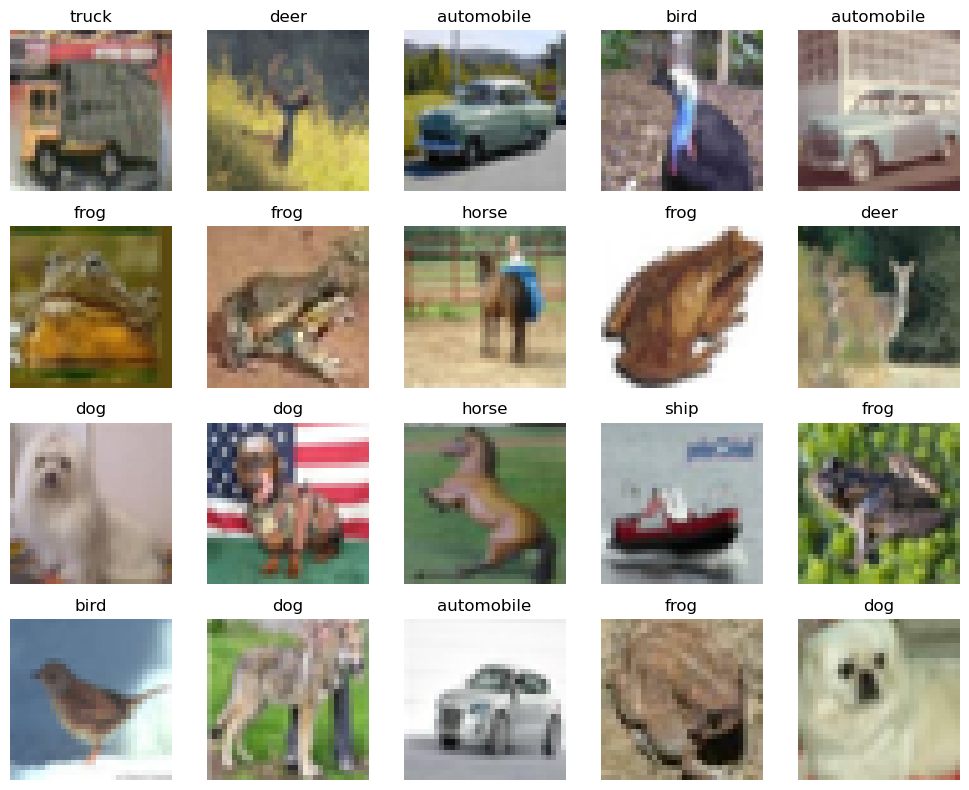

In [15]:
train_dataset, test_dataset = load_cifar10_datasets("/datasets")
visualize_few_samples(train_dataset, cols = 5, rows = 4)

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # gives (8, 14, 14)
        x = self.pool(F.relu(self.conv2(x))) # gives (16, 5, 5)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

<mark>과제</mark> ResNet50으로 CIFAR10 데이터셋을 학습하고 지난시간에 구현한 SimpleCNN 모델과 성능을 비교하라

In [21]:
def get_model(model_name, num_classes, config):
    if model_name == "resnet50":
        model = ResNet50(num_classes)
    elif model_name == "SimpleCNN":
        model = SimpleCNN()
    else:
        raise Exception("Model not supported: {}".format(model_name))
    print(f"Using model {model_name} with {sum(p.numel() for p in model.parameters())} parameters")
    return model

In [24]:
# CIFAR10 데이터셋 로딩 함수
def load_cifar10_datasets(data_root_dir):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = datasets.CIFAR10(root=data_root_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=data_root_dir, train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# DataLoader 생성 함수
def create_dataloaders(train_dataset, test_dataset, device, batch_size, num_worker):
    kwargs = {'pin_memory': True} if device.startswith('cuda') else {}
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker, **kwargs)
    return train_loader, test_loader

# 학습 및 평가 루프 정의
def train_loop(model, device, dataloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Train Accuracy 계산
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_accuracy = 100 * correct_train / total_train

    return train_loss, train_accuracy

def evaluation_loop(model, device, dataloader, criterion):
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(dataloader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy

# 학습 메인 함수
def train_main(config):
    wandb.init(project=config["wandb_project_name"], config=config)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    train_dataset, test_dataset = load_cifar10_datasets(config['data_root_dir'])
    num_classes = len(train_dataset.classes)
    train_dataloader, test_dataloader = create_dataloaders(train_dataset, test_dataset, device, config['batch_size'], config.get('num_worker', 4))

    model = get_model(config["model_name"], num_classes, config).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])

    for epoch in range(config['num_epochs']):
        train_loss, train_acc = train_loop(model, device, train_dataloader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluation_loop(model, device, test_dataloader, criterion)

        # wandb 로그 기록
        wandb.log({
            "Epoch": epoch + 1,
            "Train Accuracy": train_acc,
            "Train Loss": train_loss,
            "Validation Accuracy": val_acc,
            "Validation Loss": val_loss
        })

        print(f'Epoch {epoch + 1}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

    # wandb 종료
    wandb.finish()

In [25]:
# ResNet50 모델 학습
config = {
    'data_root_dir': '/datasets',
    'batch_size': 64,
    'learning_rate': 1e-3,
    'num_epochs': 50,
    'model_name': 'resnet50',
    "dataset": "CIFAR10",
    'wandb_project_name': 'CIFAR10_train',
    "checkpoint_save_interval": 10,
    "checkpoint_path": "checkpoints/resnet50_checkpoint.pth",
    "best_model_path": "checkpoints/resnet50_best.pth",
}
train_main(config)

# SimpleCNN 모델 학습
config['model_name'] = 'SimpleCNN'
config['checkpoint_path'] = "checkpoints/simplecnn_checkpoint.pth"
config['best_model_path'] = "checkpoints/simplecnn_best.pth"
train_main(config)

Using cuda:0 device
Files already downloaded and verified
Files already downloaded and verified
Using model resnet50 with 23528522 parameters
Epoch 1, Train Accuracy: 24.58%, Validation Accuracy: 32.72%
Epoch 2, Train Accuracy: 37.43%, Validation Accuracy: 40.80%
Epoch 3, Train Accuracy: 43.44%, Validation Accuracy: 44.95%
Epoch 4, Train Accuracy: 47.91%, Validation Accuracy: 45.98%
Epoch 5, Train Accuracy: 51.61%, Validation Accuracy: 49.61%
Epoch 6, Train Accuracy: 54.92%, Validation Accuracy: 49.31%
Epoch 7, Train Accuracy: 57.90%, Validation Accuracy: 50.51%
Epoch 8, Train Accuracy: 60.88%, Validation Accuracy: 52.44%
Epoch 9, Train Accuracy: 63.52%, Validation Accuracy: 52.58%
Epoch 10, Train Accuracy: 66.53%, Validation Accuracy: 51.27%
Epoch 11, Train Accuracy: 68.94%, Validation Accuracy: 53.15%
Epoch 12, Train Accuracy: 71.36%, Validation Accuracy: 53.19%
Epoch 13, Train Accuracy: 74.18%, Validation Accuracy: 51.32%
Epoch 14, Train Accuracy: 76.32%, Validation Accuracy: 54.11%

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇███████████████████
Train Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▅▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▆▇█▇▆▇███▇█
Validation Loss,▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▅▅▅▆█▆▅▆▇▇▆▆▆▇▆
Epoch,50
Train Accuracy,98.572
Train Loss,0.04335
Validation Accuracy,58.09
Validation Loss,2.33634


Using cuda:0 device
Files already downloaded and verified
Files already downloaded and verified
Using model SimpleCNN with 64058 parameters
Epoch 1, Train Accuracy: 10.25%, Validation Accuracy: 10.55%
Epoch 2, Train Accuracy: 10.68%, Validation Accuracy: 10.94%
Epoch 3, Train Accuracy: 11.16%, Validation Accuracy: 11.23%
Epoch 4, Train Accuracy: 11.58%, Validation Accuracy: 11.72%
Epoch 5, Train Accuracy: 11.62%, Validation Accuracy: 11.88%
Epoch 6, Train Accuracy: 11.78%, Validation Accuracy: 11.79%
Epoch 7, Train Accuracy: 11.86%, Validation Accuracy: 12.25%
Epoch 8, Train Accuracy: 13.21%, Validation Accuracy: 14.46%
Epoch 9, Train Accuracy: 14.51%, Validation Accuracy: 14.85%
Epoch 10, Train Accuracy: 14.72%, Validation Accuracy: 15.06%
Epoch 11, Train Accuracy: 15.37%, Validation Accuracy: 16.26%
Epoch 12, Train Accuracy: 17.07%, Validation Accuracy: 18.27%
Epoch 13, Train Accuracy: 19.12%, Validation Accuracy: 20.34%
Epoch 14, Train Accuracy: 21.20%, Validation Accuracy: 22.79%
E

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
Train Loss,█████████▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▂▂▂▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
Validation Loss,█████████▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,50
Train Accuracy,45.796
Train Loss,1.49116
Validation Accuracy,44.63
Validation Loss,1.51564


# Transfer learning

Transfer learning을 위해서는 먼저 dataset transform을 사전학습된 모델의 transform과 일치시켜야 한다

In [26]:
def load_cifar10_datasets(data_root_dir):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])  # pretraining에서 사용한 normalize로 수정
    
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)), # pretraining에서 사용된 이미지 사이즈로 수정
        transforms.ToTensor(),
        normalize,
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)), # pretraining에서 사용된 이미지 사이즈로 수정
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = datasets.CIFAR10(root=data_root_dir, train=True, download=True, transform=train_transforms)
    test_dataset = datasets.CIFAR10(root=data_root_dir, train=False, download=True, transform=test_transforms)

    return train_dataset, test_dataset

아래와 같이 PyTorch에서 제공하는 pre-trained model의 weight를 가져올 수 있다.

PyTorch에서 제공하는 다른 pre-trained model들은 [링크](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights)를 참조하기 바람

In [27]:
model = models.resnet50(weights = 'IMAGENET1K_V2')

먼저 모델의 구조를 살펴보자.

In [28]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
for name, param in model.named_parameters():
    print(f"{name:<35} {param.shape}")

conv1.weight                        torch.Size([64, 3, 7, 7])
bn1.weight                          torch.Size([64])
bn1.bias                            torch.Size([64])
layer1.0.conv1.weight               torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight                 torch.Size([64])
layer1.0.bn1.bias                   torch.Size([64])
layer1.0.conv2.weight               torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight                 torch.Size([64])
layer1.0.bn2.bias                   torch.Size([64])
layer1.0.conv3.weight               torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight                 torch.Size([256])
layer1.0.bn3.bias                   torch.Size([256])
layer1.0.downsample.0.weight        torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight        torch.Size([256])
layer1.0.downsample.1.bias          torch.Size([256])
layer1.1.conv1.weight               torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight                 torch.Size([64])
layer1.1.bn1.bias                

Transfer learning을 위해서는 두가지가 필요하다.
1. 마지막 레이어의 logit 출력 차원을 데이터셋에 적합하게 수정 (out_features = 10 for CIFAR10 dataset)
2. 학습할 layer를 설정

아래와 같은 코드를 통해 마지막 레이어인 fc layer를 수정할 수 있다.

In [29]:
model.fc = nn.Linear(model.fc.in_features, 10)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

아래와 같은 코드를 통해 학습하고자 하는 파라미터를 설정할 수 있다.

In [30]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f"{name:<30} Param shape: {str(param.shape):<30} requires_grad: {param.requires_grad}")

conv1.weight                   Param shape: torch.Size([64, 3, 7, 7])      requires_grad: False
bn1.weight                     Param shape: torch.Size([64])               requires_grad: False
bn1.bias                       Param shape: torch.Size([64])               requires_grad: False
layer1.0.conv1.weight          Param shape: torch.Size([64, 64, 1, 1])     requires_grad: False
layer1.0.bn1.weight            Param shape: torch.Size([64])               requires_grad: False
layer1.0.bn1.bias              Param shape: torch.Size([64])               requires_grad: False
layer1.0.conv2.weight          Param shape: torch.Size([64, 64, 3, 3])     requires_grad: False
layer1.0.bn2.weight            Param shape: torch.Size([64])               requires_grad: False
layer1.0.bn2.bias              Param shape: torch.Size([64])               requires_grad: False
layer1.0.conv3.weight          Param shape: torch.Size([256, 64, 1, 1])    requires_grad: False
layer1.0.bn3.weight            Param sha

<mark>과제</mark>
`get_model` 함수를 완성하여 CIFAR10데이터셋에 대한 transfer learning을 수행하라.

`fc` 와 `layer4`만 학습하고 나머지 파라미터는 동결시킬것

In [31]:
def get_model(model_name, num_classes, config):
    if model_name == "resnet50":
        if config.get('pretrained', ""): #if pretrained model name is given
            print(f'Using pretrained model {config["pretrained"]}')
            model = models.resnet50(weights = config["pretrained"])

            ##### YOUR CODE START #####
            model.fc = nn.Linear(model.fc.in_features, num_classes)

            # 모든 파라미터 동결.
            for param in model.parameters():
                param.requires_grad = False

            # layer4와 fc 레이어의 파라미터만 학습 가능하도록 설정.
            for param in model.layer4.parameters():
                param.requires_grad = True
            for param in model.fc.parameters():
                param.requires_grad = True
            ##### YOUR CODE END #####
                
        else:
            model = models.resnet50()
            model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "SimpleCNN":
        model = SimpleCNN()
    else:
        raise Exception("Model not supported: {}".format(model_name))
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Using model {model_name} with {total_params} parameters ({trainable_params} trainable)")

    return model


In [32]:
config = {
    'data_root_dir': '/datasets',
    'batch_size': 64,
    'learning_rate': 1e-3,
    'num_epochs': 50,
    'model_name': 'resnet50',
    'pretrained' : 'IMAGENET1K_V2',
    "dataset": "CIFAR10",
    'wandb_project_name': 'CIFAR10_train',

    "checkpoint_save_interval" : 10,
    "checkpoint_path" : "checkpoints/checkpoint.pth",
    "best_model_path" : "checkpoints/best_model.pth",
    "load_from_checkpoint" : None,    # Options: "latest", "best", or None
}
train_main(config)

Using cuda:0 device
Files already downloaded and verified
Files already downloaded and verified
Using pretrained model IMAGENET1K_V2
Using model resnet50 with 23528522 parameters (14985226 trainable)
Epoch 1, Train Accuracy: 44.17%, Validation Accuracy: 63.86%
Epoch 2, Train Accuracy: 67.73%, Validation Accuracy: 71.87%
Epoch 3, Train Accuracy: 72.68%, Validation Accuracy: 74.85%
Epoch 4, Train Accuracy: 75.23%, Validation Accuracy: 77.10%
Epoch 5, Train Accuracy: 77.02%, Validation Accuracy: 78.71%
Epoch 6, Train Accuracy: 78.17%, Validation Accuracy: 80.08%
Epoch 7, Train Accuracy: 79.66%, Validation Accuracy: 80.73%
Epoch 8, Train Accuracy: 80.79%, Validation Accuracy: 81.53%
Epoch 9, Train Accuracy: 81.63%, Validation Accuracy: 82.13%
Epoch 10, Train Accuracy: 82.33%, Validation Accuracy: 82.74%
Epoch 11, Train Accuracy: 83.02%, Validation Accuracy: 83.20%
Epoch 12, Train Accuracy: 83.59%, Validation Accuracy: 83.29%
Epoch 13, Train Accuracy: 84.07%, Validation Accuracy: 83.82%
Epo

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Train Loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████████████
Validation Loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,50
Train Accuracy,93.994
Train Loss,0.18367
Validation Accuracy,88.03
Validation Loss,0.35852


#### 선택 과제 (optional)
transfer learning 코드를 수정하여 다양한 layer를 freeze/unfreeze해보고 가장 성능이 좋은 transfer learning조건을 찾아보자.

<mark>주의</mark> 추가 실습을 하기 전 완성한 과제를 git push하여, 추가실험으로 인한 변화가 제출되지 않도록 주의할것

#### Lab을 마무리 짓기 전 저장된 checkpoint를 모두 지워 저장공간을 확보한다

In [1]:
import shutil
shutil.rmtree('checkpoints/')